In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    color_isla = 'blue'
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_Tenerife = datos[datos['isla'] == 'TENERIFE']

datos_Tenerife = datos_Tenerife.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'Tenerife'         # Isla a la que se está realziando el estudio
fechas = datos_Tenerife.tail(dias_prediccion).index # Fechas de los días a predecir


variables_covid = [objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = [objetivo, 'tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = [objetivo,'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables


In [5]:

# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_Tenerife_uni = datos_Tenerife[objetivo]
datos_Tenerife_uni_arr = np.array(datos_Tenerife_uni).reshape(-1, 1)

datos_Tenerife_mult_covid = datos_Tenerife[variables_covid]
datos_Tenerife_mult_atm = datos_Tenerife[variables_atm]
datos_Tenerife_mult_total = datos_Tenerife[variables]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_uni_scaled = scaler.fit_transform(datos_Tenerife_uni_arr)

In [7]:
n_train = len(datos_Tenerife_uni_scaled) - dias_prediccion


train = datos_Tenerife_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_uni_scaled[n_train - dias_prediccion:len(datos_Tenerife_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 6s 145ms/step - loss: 0.0388 - val_loss: 0.0210
Epoch 2/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0351 - val_loss: 0.0194
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0330 - val_loss: 0.0182
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0314 - val_loss: 0.0173
Epoch 5/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0294 - val_loss: 0.0170
Epoch 6/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0269 - val_loss: 0.0157
Epoch 7/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0252 - val_loss: 0.0155
Epoch 8/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0228 - val_loss: 0.0147
Epoch 9/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0203 - val_loss: 0.0142
Epoch 10/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0207 - val_loss: 0.0135
Epoch 11/50
7/7 [===========

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 1s 532ms/step


In [11]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 703.75433
2022-03-20: número de casos reales 193, número de casos predichos 672.70026
2022-03-21: número de casos reales 636, número de casos predichos 641.4599
2022-03-22: número de casos reales 760, número de casos predichos 599.7076
2022-03-23: número de casos reales 716, número de casos predichos 621.78925
2022-03-24: número de casos reales 607, número de casos predichos 658.47095
2022-03-25: número de casos reales 636, número de casos predichos 594.2603
2022-03-26: número de casos reales 266, número de casos predichos 528.6518
2022-03-27: número de casos reales 163, número de casos predichos 495.7975
2022-03-28: número de casos reales 319, número de casos predichos 486.30908


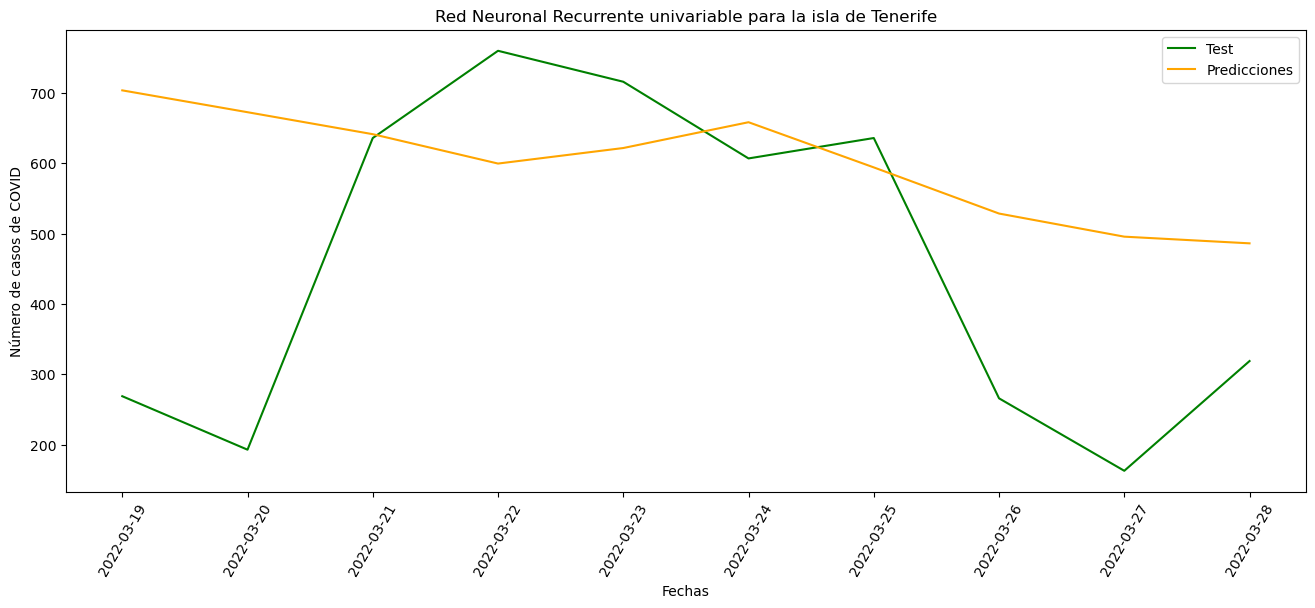

In [12]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

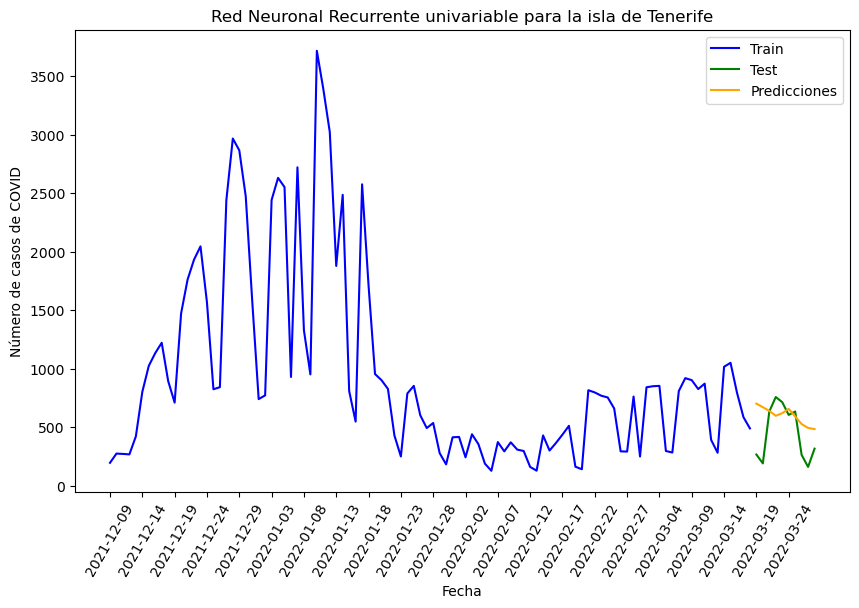

In [13]:
datos_train = datos_Tenerife_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [14]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 66584.67229389065
Error absoluto medio (MAE) del modelo: 203.03866577148438
Raíz del error cuadrático medio (RMSE) del modelo: 258.0400594750564


# Red Neuronal Recurrente multivariable con variables de pandemia

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled = scaler.fit_transform(datos_Tenerife_mult_covid)


# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_covid[objetivo]).reshape(-1, 1))

In [16]:
n_train = len(datos_Tenerife_mult_covid_scaled) - dias_prediccion


train = datos_Tenerife_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_covid_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_covid_scaled), :]

In [17]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [18]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 7s 133ms/step - loss: 0.0385 - val_loss: 0.0229
Epoch 2/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0323 - val_loss: 0.0214
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0290 - val_loss: 0.0207
Epoch 4/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0275 - val_loss: 0.0197
Epoch 5/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0249 - val_loss: 0.0192
Epoch 6/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0240 - val_loss: 0.0192
Epoch 7/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0249 - val_loss: 0.0199
Epoch 8/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0228 - val_loss: 0.0176
Epoch 9/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0216 - val_loss: 0.0165
Epoch 10/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0227 - val_loss: 0.0177
Epoch 11/50
7/7 [===========

In [19]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 1s 624ms/step


In [20]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 822.5279
2022-03-20: número de casos reales 193, número de casos predichos 784.3046
2022-03-21: número de casos reales 636, número de casos predichos 746.28564
2022-03-22: número de casos reales 760, número de casos predichos 706.2757
2022-03-23: número de casos reales 716, número de casos predichos 735.16864
2022-03-24: número de casos reales 607, número de casos predichos 783.9935
2022-03-25: número de casos reales 636, número de casos predichos 733.15814
2022-03-26: número de casos reales 266, número de casos predichos 686.3007
2022-03-27: número de casos reales 163, número de casos predichos 656.14624
2022-03-28: número de casos reales 319, número de casos predichos 646.77405


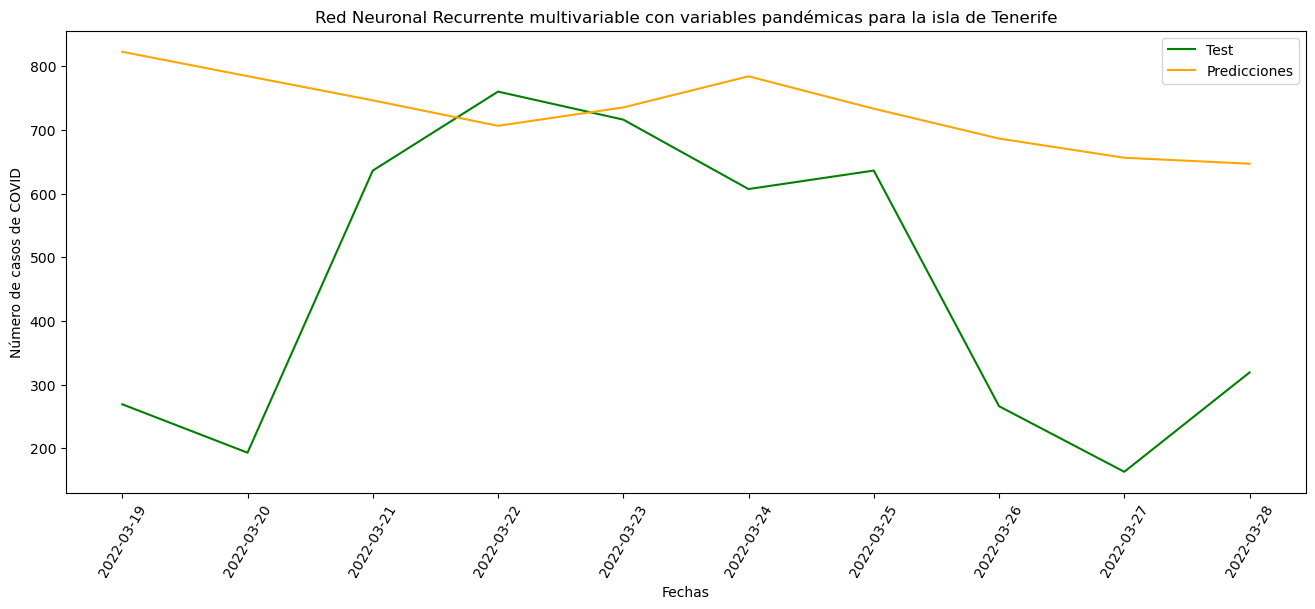

In [21]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

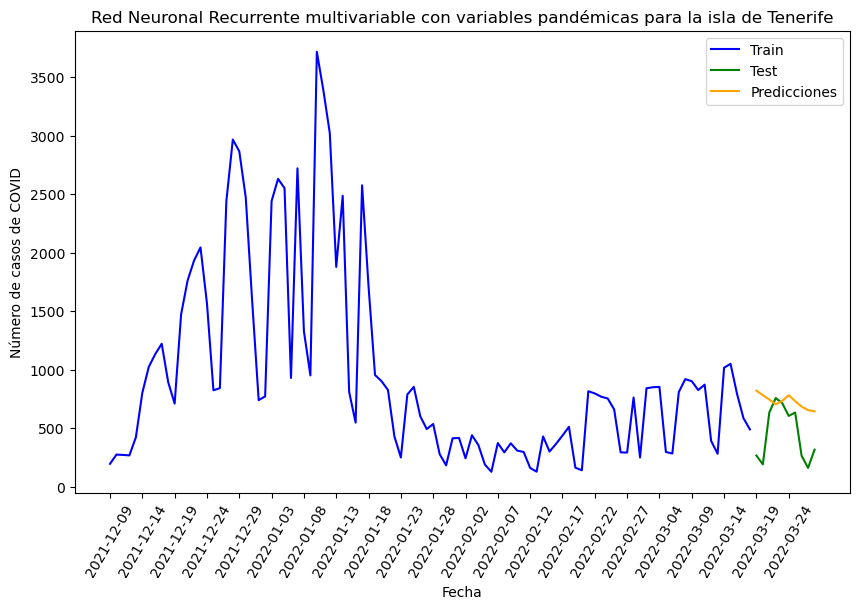

In [22]:
datos_train = datos_Tenerife_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [23]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 123949.9101145737
Error absoluto medio (MAE) del modelo: 284.33837890625
Raíz del error cuadrático medio (RMSE) del modelo: 352.06520719118737


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled = scaler.fit_transform(datos_Tenerife_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_atm[objetivo]).reshape(-1, 1))

In [25]:
n_train = len(datos_Tenerife_mult_atm_scaled) - dias_prediccion


train = datos_Tenerife_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_atm_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_atm_scaled), :]

In [26]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [27]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 7s 241ms/step - loss: 0.0440 - val_loss: 0.0261
Epoch 2/50
7/7 [==============================] - 0s 20ms/step - loss: 0.0397 - val_loss: 0.0238
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0379 - val_loss: 0.0216
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0358 - val_loss: 0.0207
Epoch 5/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0332 - val_loss: 0.0206
Epoch 6/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0310 - val_loss: 0.0185
Epoch 7/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0290 - val_loss: 0.0179
Epoch 8/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0283 - val_loss: 0.0201
Epoch 9/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0249 - val_loss: 0.0196
Epoch 10/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0230 - val_loss: 0.0165
Epoch 11/50
7/7 [===========

In [28]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 303ms/step


In [29]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 682.7509
2022-03-20: número de casos reales 193, número de casos predichos 644.0982
2022-03-21: número de casos reales 636, número de casos predichos 607.4682
2022-03-22: número de casos reales 760, número de casos predichos 557.7561
2022-03-23: número de casos reales 716, número de casos predichos 572.0926
2022-03-24: número de casos reales 607, número de casos predichos 597.4006
2022-03-25: número de casos reales 636, número de casos predichos 537.74347
2022-03-26: número de casos reales 266, número de casos predichos 473.47394
2022-03-27: número de casos reales 163, número de casos predichos 439.224
2022-03-28: número de casos reales 319, número de casos predichos 430.44516


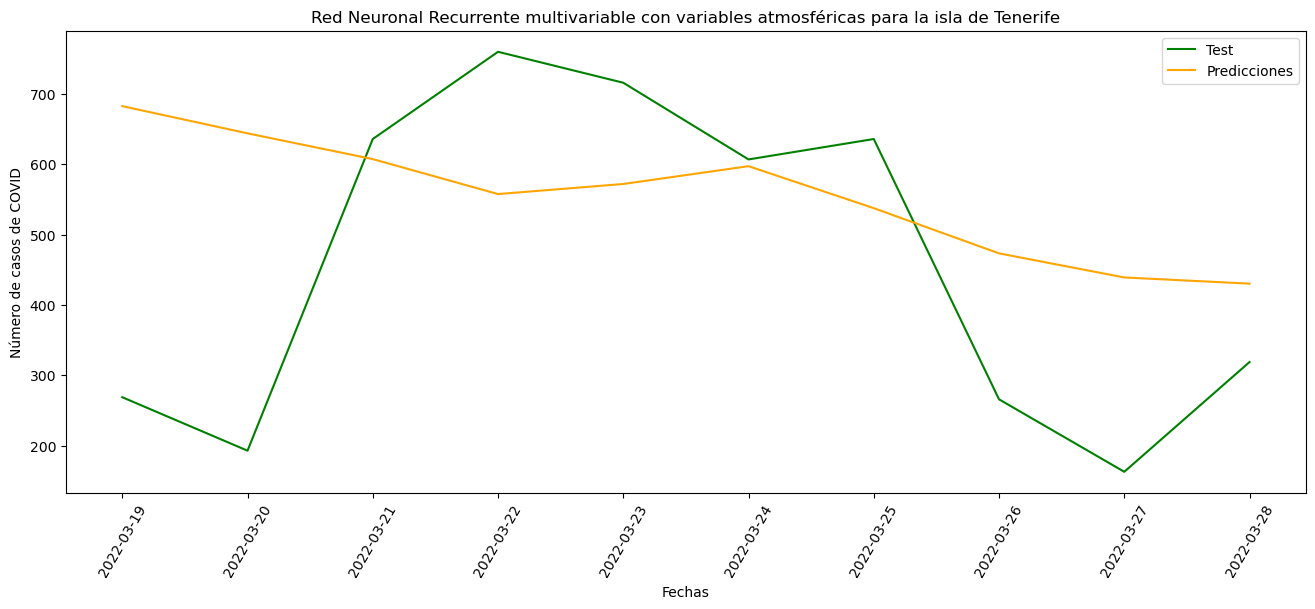

In [30]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

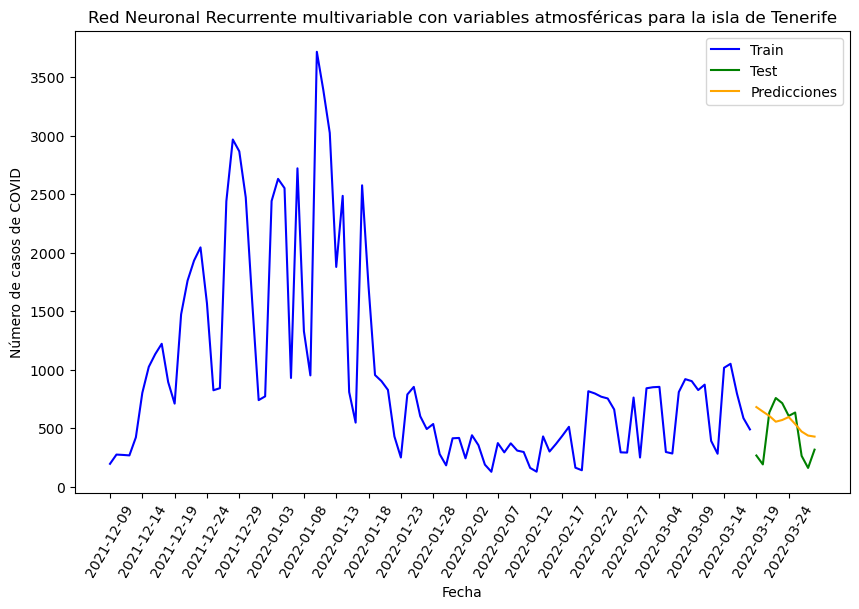

In [31]:
datos_train = datos_Tenerife_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [32]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 57861.70620304393
Error absoluto medio (MAE) del modelo: 194.2531280517578
Raíz del error cuadrático medio (RMSE) del modelo: 240.54460335464591


# Red Neuronal Recurrente multivariable con todas las variables

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled = scaler.fit_transform(datos_Tenerife_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_total[objetivo]).reshape(-1, 1))

In [34]:
n_train = len(datos_Tenerife_mult_total_scaled) - dias_prediccion


train = datos_Tenerife_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_total_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_total_scaled), :]

In [35]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [36]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 3s 76ms/step - loss: 0.0442 - val_loss: 0.0285
Epoch 2/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0388 - val_loss: 0.0252
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0351 - val_loss: 0.0245
Epoch 4/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0320 - val_loss: 0.0230
Epoch 5/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0301 - val_loss: 0.0227
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0291 - val_loss: 0.0216
Epoch 7/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0256 - val_loss: 0.0223
Epoch 8/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0256 - val_loss: 0.0245
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0245 - val_loss: 0.0211
Epoch 10/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0236 - val_loss: 0.0205
Epoch 11/50
7/7 [============

In [37]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 301ms/step


In [38]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 809.39124
2022-03-20: número de casos reales 193, número de casos predichos 775.5329
2022-03-21: número de casos reales 636, número de casos predichos 747.1404
2022-03-22: número de casos reales 760, número de casos predichos 691.4348
2022-03-23: número de casos reales 716, número de casos predichos 726.5522
2022-03-24: número de casos reales 607, número de casos predichos 768.0288
2022-03-25: número de casos reales 636, número de casos predichos 714.5815
2022-03-26: número de casos reales 266, número de casos predichos 640.00665
2022-03-27: número de casos reales 163, número de casos predichos 593.073
2022-03-28: número de casos reales 319, número de casos predichos 576.9616


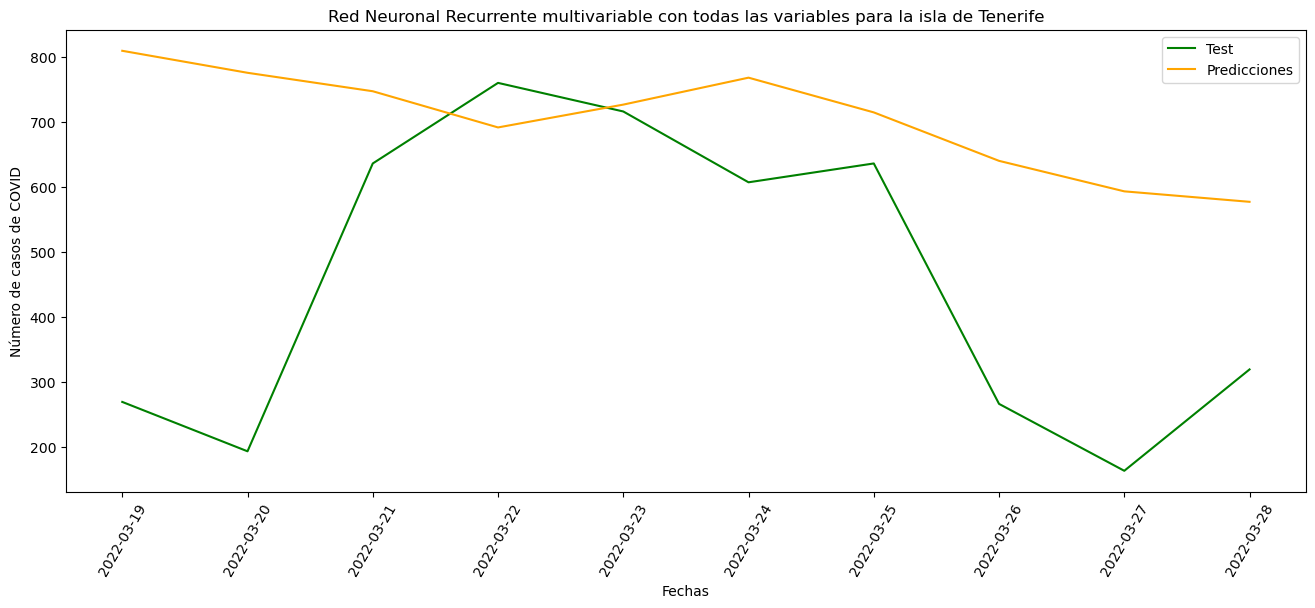

In [39]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

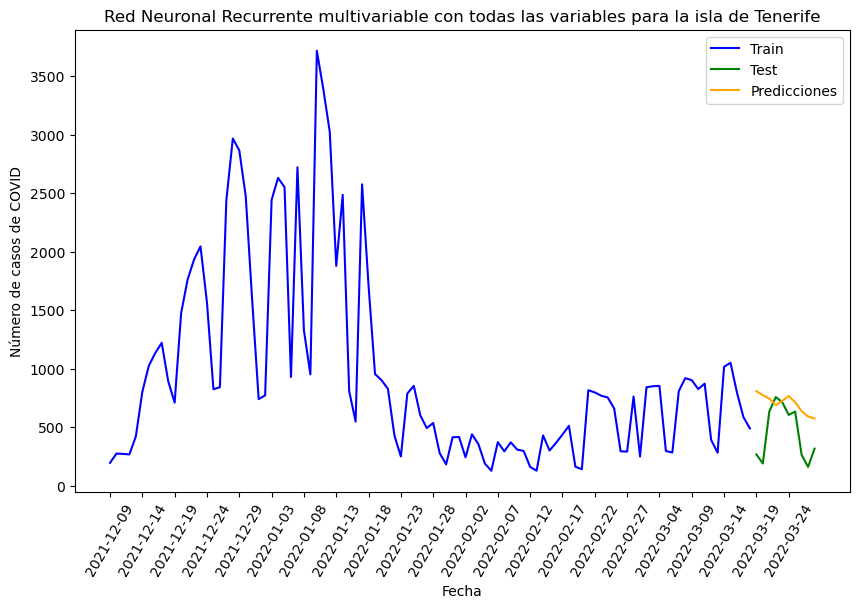

In [40]:
datos_train = datos_Tenerife_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [41]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 107202.52601451315
Error absoluto medio (MAE) del modelo: 261.48334350585935
Raíz del error cuadrático medio (RMSE) del modelo: 327.41796837454285
